In [1]:
import os
import sys
import random
import warnings

import numpy as np
import math

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

TRAIN_PATH = 'Input/stage1_train/'
TEST_PATH = 'Input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# These lists will be used to store the images.
imgs = []
masks = []

# These lists will be used to store the image metadata that will then be used to create
# pandas dataframes.
img_data = []
mask_data = []
print('Processing images ... ')

# Loop over the training images. tqdm is used to display progress as reading
# all the images can take about 1 - 2 minutes.
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    # Get image.
    imgs.append(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_area = img_width * img_height

    # Initialize counter. There is one mask for each annotated nucleus.
    nucleus_count = 1
    
    # Loop over the mask ids, read the images and gather metadata from them.
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask = imread(path + '/masks/' + mask_file)
        masks.append(mask)
        mask_height = mask.shape[0]
        mask_width = mask.shape[1]
        mask_area = mask_width * img_height
        
        # Sum and divide by 255 to get the number
        # of pixels for the nucleus. Masks are grayscale.
        nucleus_area = (np.sum(mask) / 255)
        
        mask_to_img_ratio = nucleus_area / mask_area
        
        # Append to masks data list that will be used to create a pandas dataframe.
        mask_data.append([n, mask_height, mask_width, mask_area, nucleus_area, mask_to_img_ratio])
        
        # Increment nucleus count.
        nucleus_count = nucleus_count + 1
    
    # Build image info list that will be used to create dataframe. This is done after the masks loop
    # because we want to store the number of nuclei per image in the img_data list.
    img_data.append([img_height, img_width, img_area, nucleus_count])

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

Processing images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:00<00:00, 11.11it/s]


In [6]:
# Create dataframe for images
df_img = pd.DataFrame(img_data, columns=['height', 'width', 'area', 'nuclei'])

In [7]:
df_img.describe()

,height,width,area,nuclei
count,670.000000,670.000000,6.700000e+02,670.000000
mean,333.991045,378.500000,1.547583e+05,44.971642
std,149.474845,204.838693,1.908250e+05,47.962530
min,256.000000,256.000000,6.553600e+04,2.000000
25%,256.000000,256.000000,6.553600e+04,16.250000
50%,256.000000,320.000000,8.192000e+04,28.000000
75%,360.000000,360.000000,1.296000e+05,55.000000
max,1040.000000,1388.000000,1.443520e+06,376.000000


In [8]:
df_img.head()

,height,width,area,nuclei
0,256,256,65536,28
1,256,256,65536,37
2,256,320,81920,71
3,256,320,81920,87
4,256,320,81920,8


In [9]:
df_img.tail()

,height,width,area,nuclei
665,256,256,65536,14
666,256,256,65536,39
667,520,696,361920,20
668,256,256,65536,14
669,360,360,129600,25


In [10]:
# Create dataframe for masks
df_mask = pd.DataFrame(mask_data, columns=['img_index', 'height', 'width', 'area', 'nucleus_area', 'mask_to_img_ratio'])

In [11]:
df_mask.describe()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
count,29461.000000,29461.000000,29461.000000,2.946100e+04,29461.000000,29461.000000
mean,328.021724,404.408642,506.068090,2.511955e+05,471.803707,0.003165
std,192.007063,187.400013,282.185678,2.516759e+05,583.837040,0.004488
min,0.000000,256.000000,256.000000,6.553600e+04,21.000000,0.000020
25%,168.000000,256.000000,256.000000,6.553600e+04,118.000000,0.000992
50%,319.000000,360.000000,360.000000,1.296000e+05,305.000000,0.001724
75%,497.000000,520.000000,696.000000,3.619200e+05,574.000000,0.003376
max,669.000000,1040.000000,1388.000000,1.443520e+06,11037.000000,0.083557


In [12]:
df_mask.head()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
0,0,256,256,65536,259.0,0.003952
1,0,256,256,65536,112.0,0.001709
2,0,256,256,65536,353.0,0.005386
3,0,256,256,65536,174.0,0.002655
4,0,256,256,65536,198.0,0.003021


In [13]:
df_mask.tail()

,img_index,height,width,area,nucleus_area,mask_to_img_ratio
29456,669,360,360,129600,1087.0,0.008387
29457,669,360,360,129600,1863.0,0.014375
29458,669,360,360,129600,957.0,0.007384
29459,669,360,360,129600,2456.0,0.018951
29460,669,360,360,129600,2702.0,0.020849


Plot image with large amount of nucleus

421


c:\users\alina\.virtualenvs\semseg-aqhuslpm\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


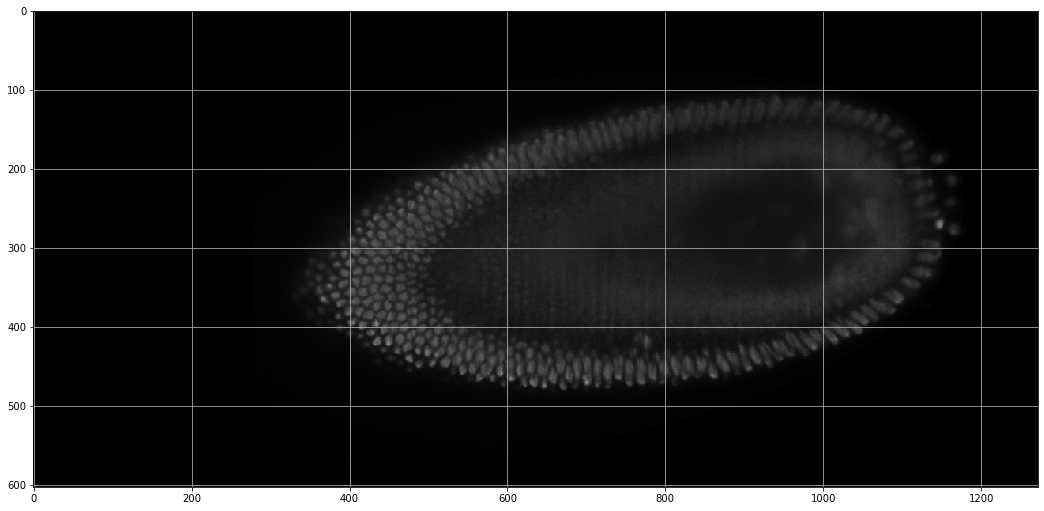

In [14]:
plt.figure(figsize=(18, 18))
much_nuclei = df_img['nuclei'].argmax()
print(much_nuclei)
plt.grid(None)
plt.imshow(imgs[much_nuclei])

Plot image with small amount of nucleus

2


c:\users\alina\.virtualenvs\semseg-aqhuslpm\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


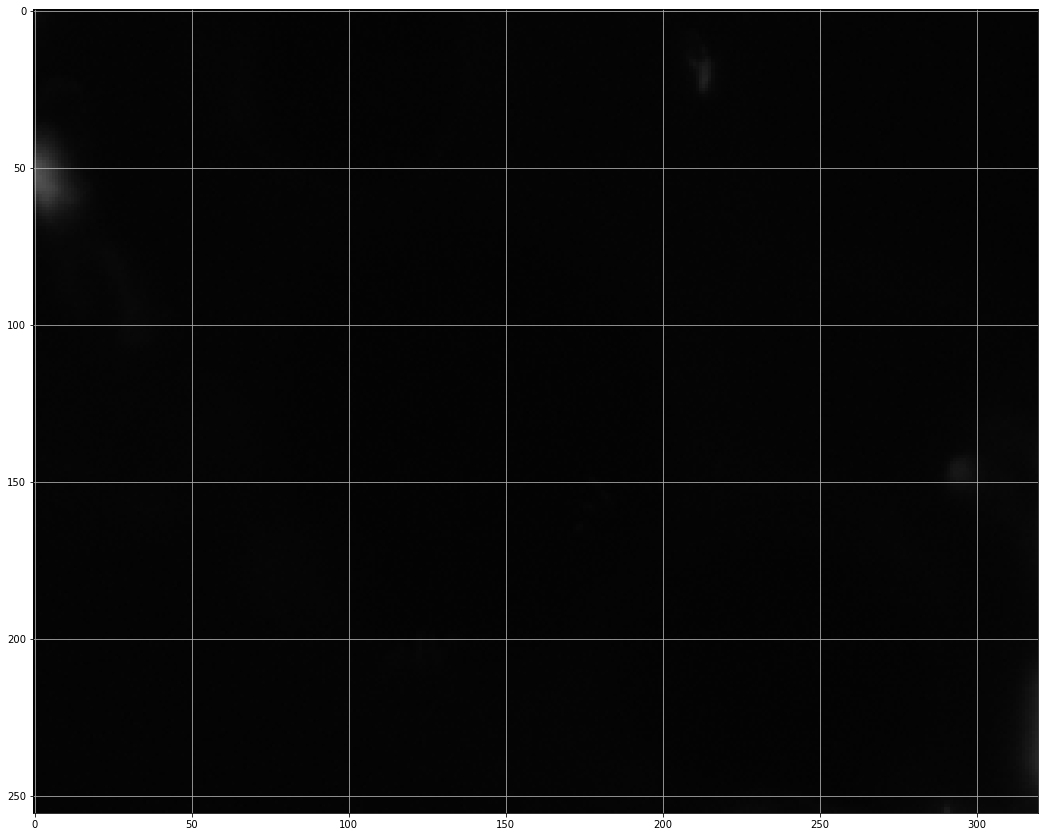

In [15]:
plt.figure(figsize=(18, 18))
not_much_nuclei = df_img['nuclei'].argmin()
print(df_img['nuclei'].min())
plt.grid(None)
plt.imshow(imgs[not_much_nuclei])

Pictures of different nuclei sizes and shapes.

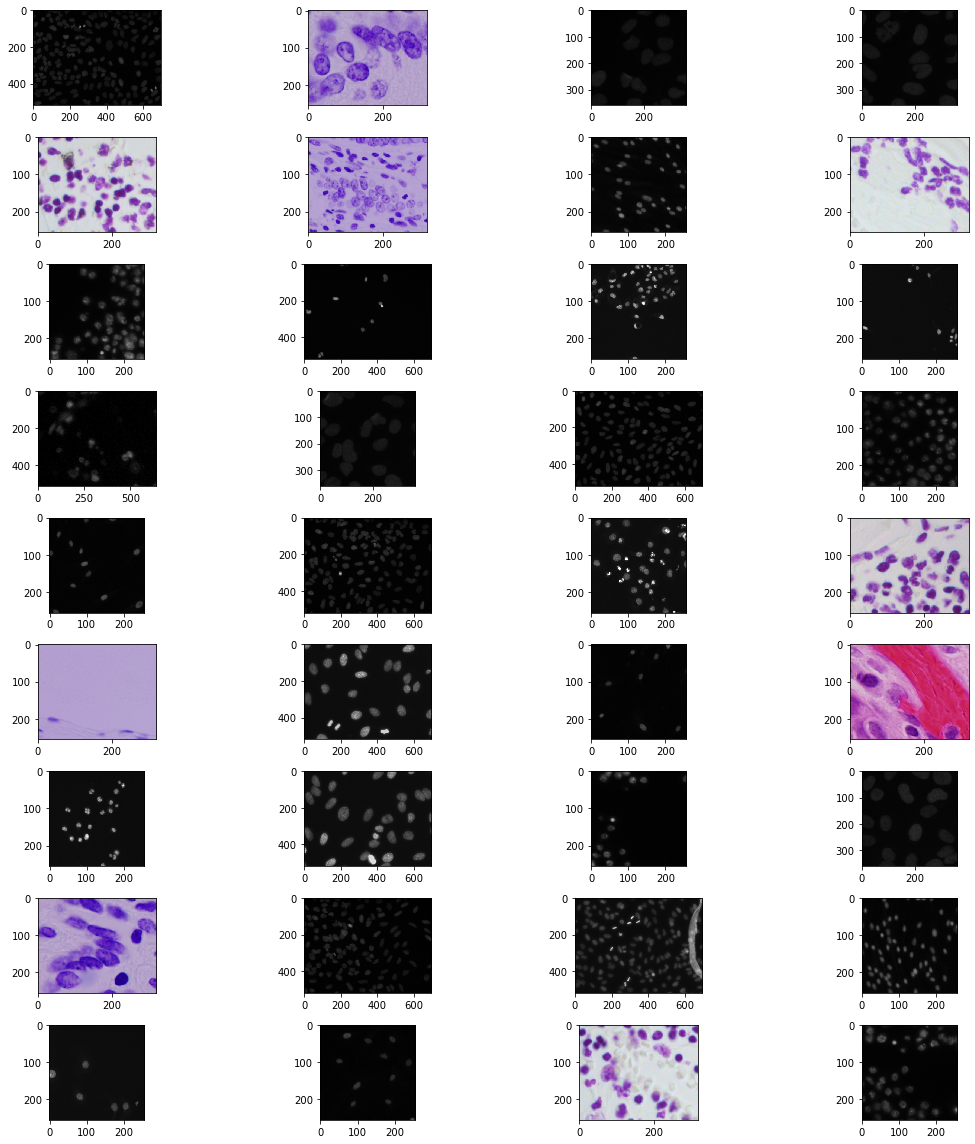

In [16]:
sample_nuclei = df_img.sample(36).index
fig, ax = plt.subplots(9, 4, figsize=(16, 16))
row = 0
col = 0
for i, img_id in enumerate(sample_nuclei):
    ax[row, col].grid(False)
    ax[row, col].imshow(imgs[img_id])
    
    # Increment col index and reset each time
    # it gets to 4 to start a new row
    col = col + 1
    if(col == 4):
        col = 0
    
    # Increment row index every 4 items
    if((i + 1) % 4 == 0):
        row = row + 1
plt.tight_layout()